In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
import os
sys.path.append(os.path.join("./", "..", ".."))

In [2]:
from Model import *

In [3]:
model = Model.Initialize('vae', None, pretrained_path='./../../Models/vae.pt')

Loading the pretrained model...


In [4]:
# sys.path.insert(0, "../Code/")
# from load_scvis import load_vae

path = './../../ELDR/Housing/Data/'


data_file = path + 'X.tsv'
target_file = path + 'y.tsv'
input_dim = 13
#model_file = "Model/model/perplexity_10_regularizer_0.001_batch_size_505_learning_rate_0.01_latent_dimension_2_activation_ELU_seed_1_iter_3000.ckpt"
num_clusters = 6

x = pd.read_csv(data_file, sep="\t").values
y = pd.read_csv(target_file, sep="\t").values



data_rep = model.Encode(x)

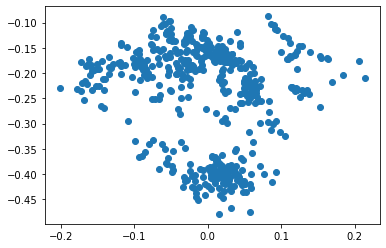

In [5]:
plt.scatter(data_rep[:,0], data_rep[:,1])

In [6]:
from sklearn.cluster import KMeans
num_clusters = 6

kmeans = KMeans(n_clusters = num_clusters).fit(data_rep)

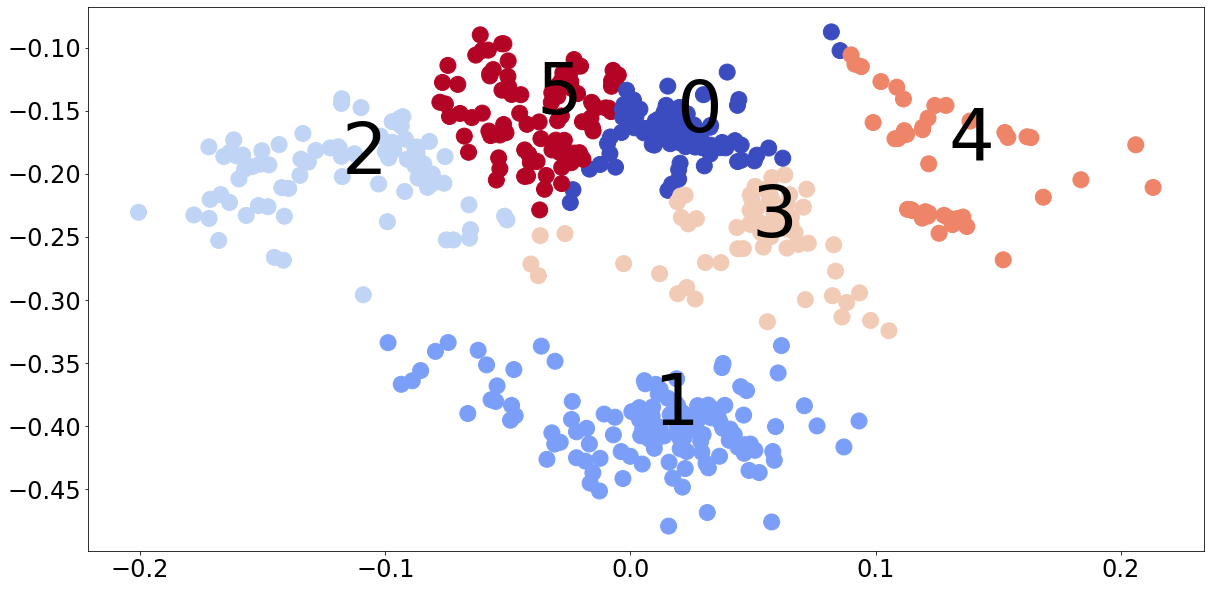

In [7]:
from eldr.plotter.myplot import *
means, centers, indices = plot_groups(x, data_rep.numpy(), num_clusters, kmeans.labels_, name = "./synth-rep.png")

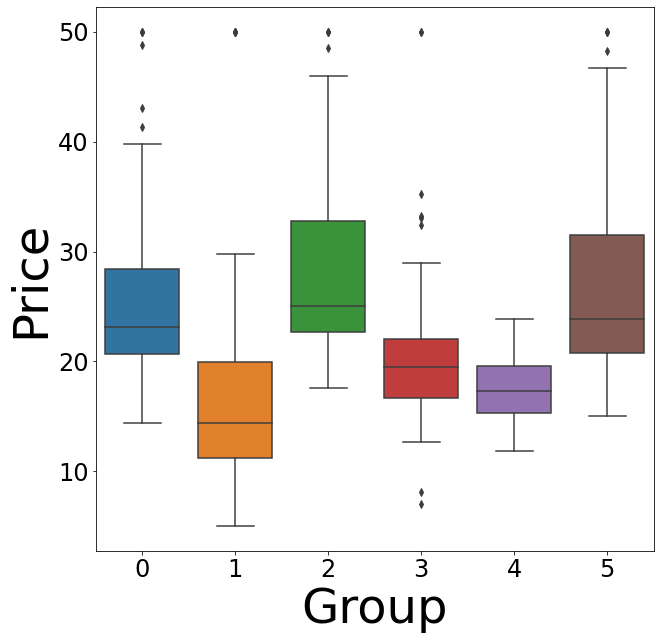

In [8]:
# See what signal is enocded in the clusters
import matplotlib.pyplot as plt
import seaborn as sns

labels = kmeans.labels_

fig, ax = plt.subplots(figsize=(10, 10))
sns.boxplot(ax = ax, x = labels, y = np.squeeze(y))
ax.set(xlabel = "Group", ylabel = "Price")
ax.get_figure().savefig("housing-labels.png")


[[ 0.11820733  0.22108531 -0.17610458  0.1073094   0.03312087 -0.03694274
   0.3688885   0.04959817  0.35634917  0.43660694  0.45740375 -0.16469471
   0.14379896]
 [ 0.01581318  0.23061468 -0.0323565   0.05447436 -0.4151136   0.05600335
  -0.08938883  0.12484196  0.10731551  0.04390511 -0.1659343   0.05981994
  -0.08137032]
 [ 0.02272517  0.01612778 -0.1087568  -0.03393539  0.14033727 -0.03657784
   0.1331947  -0.01035969  0.14994426  0.1771272   0.18013072 -0.00390471
   0.1106768 ]
 [-0.00894068 -0.10662052 -0.02416693  0.05868972  0.28432515 -0.11259984
   0.13031271 -0.09027286 -0.05322835  0.04437421  0.22226338  0.01637826
  -0.00317315]
 [-0.00028313  0.0770671   0.04866315  0.00671225 -0.18839453 -0.00325494
  -0.04711958  0.05473356  0.00246713 -0.03342023 -0.11068276  0.04112078
  -0.07814784]]


./../../eldr/plotter/myplot.py:105: MatplotlibDeprecationWarning: Since 3.2, mpl_toolkits's own colorbar implementation is deprecated; it will be removed two minor releases later.  Set the 'mpl_toolkits.legacy_colorbar' rcParam to False to use Matplotlib's default colorbar implementation and suppress this deprecation warning.
  ax.cax.colorbar(im)
/home2/tirthankar/miniconda3_1/envs/rajeev3/lib/python3.7/site-packages/mpl_toolkits/axes_grid1/axes_grid.py:46: MatplotlibDeprecationWarning: 
The mpl_toolkits.axes_grid1.colorbar module was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use matplotlib.colorbar instead.
  from .colorbar import Colorbar


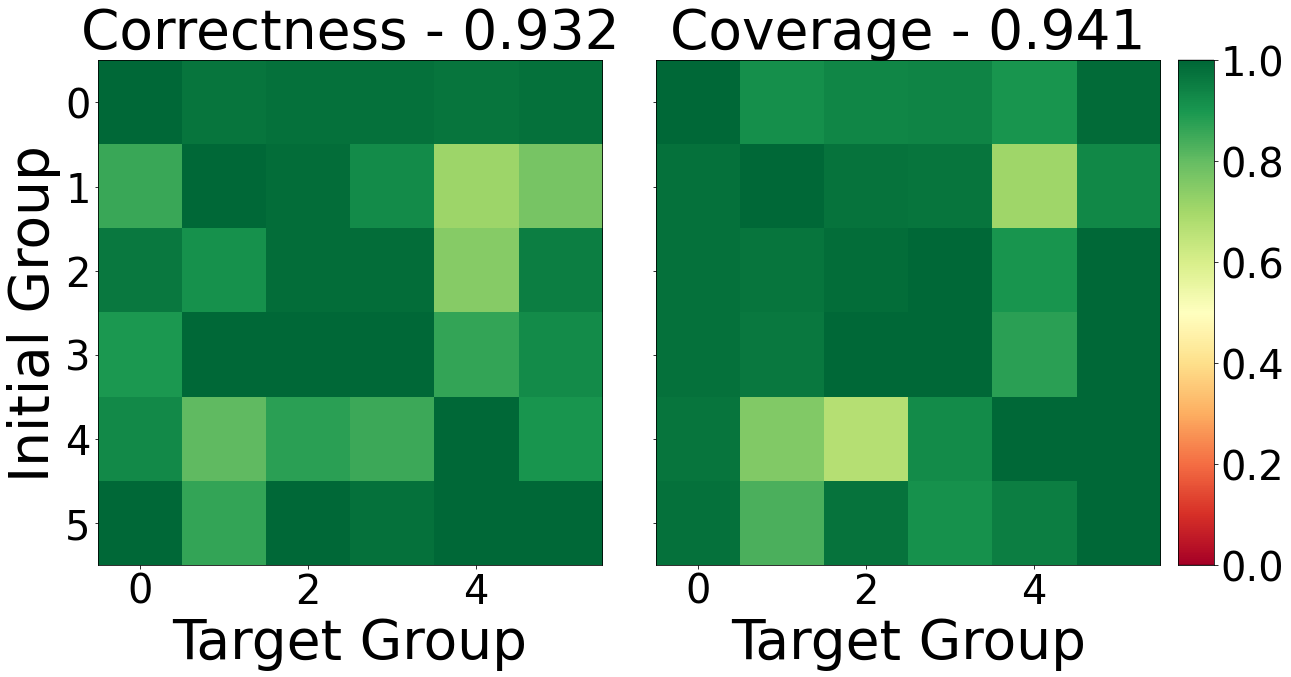

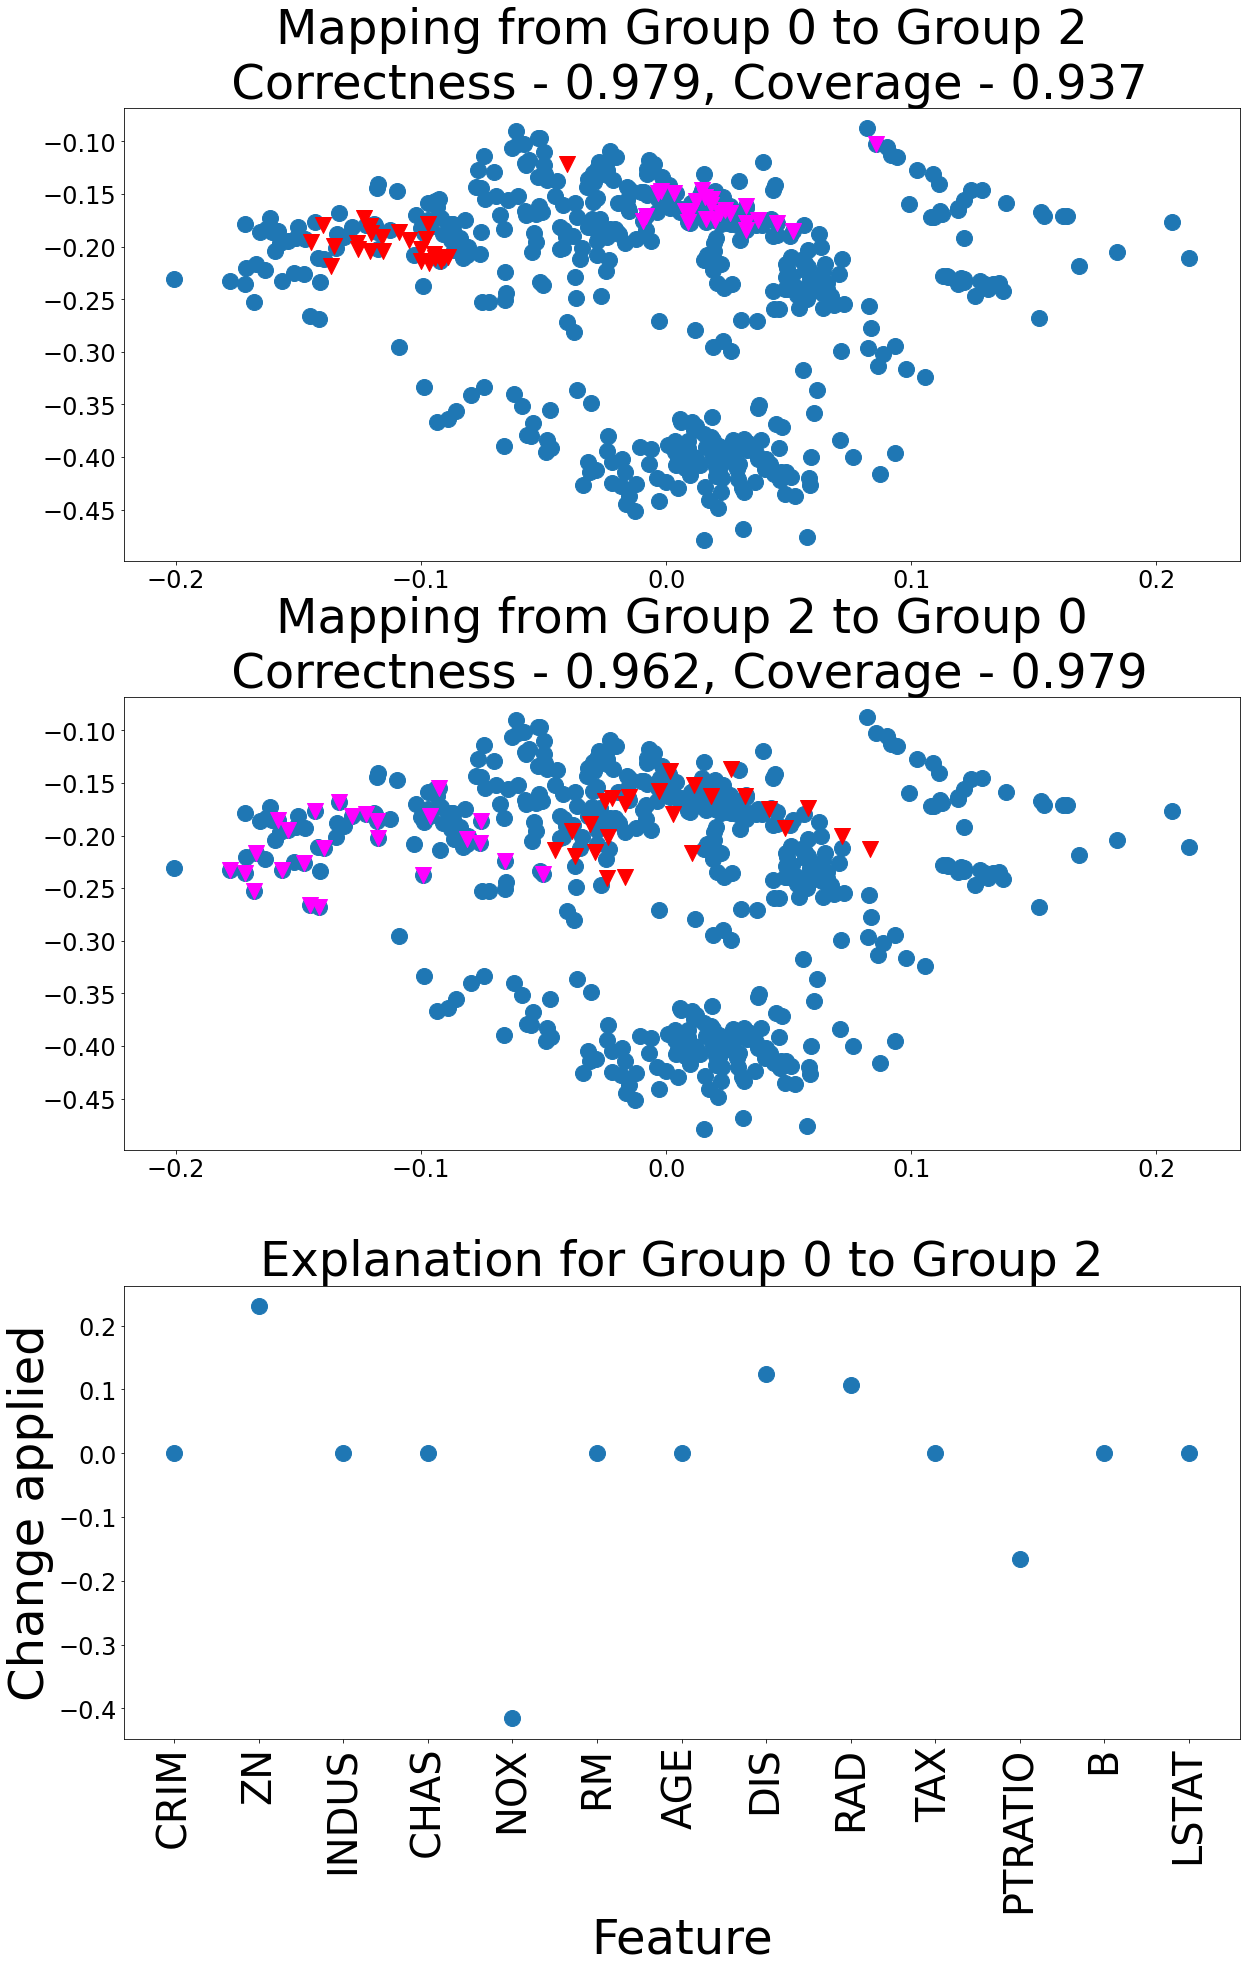

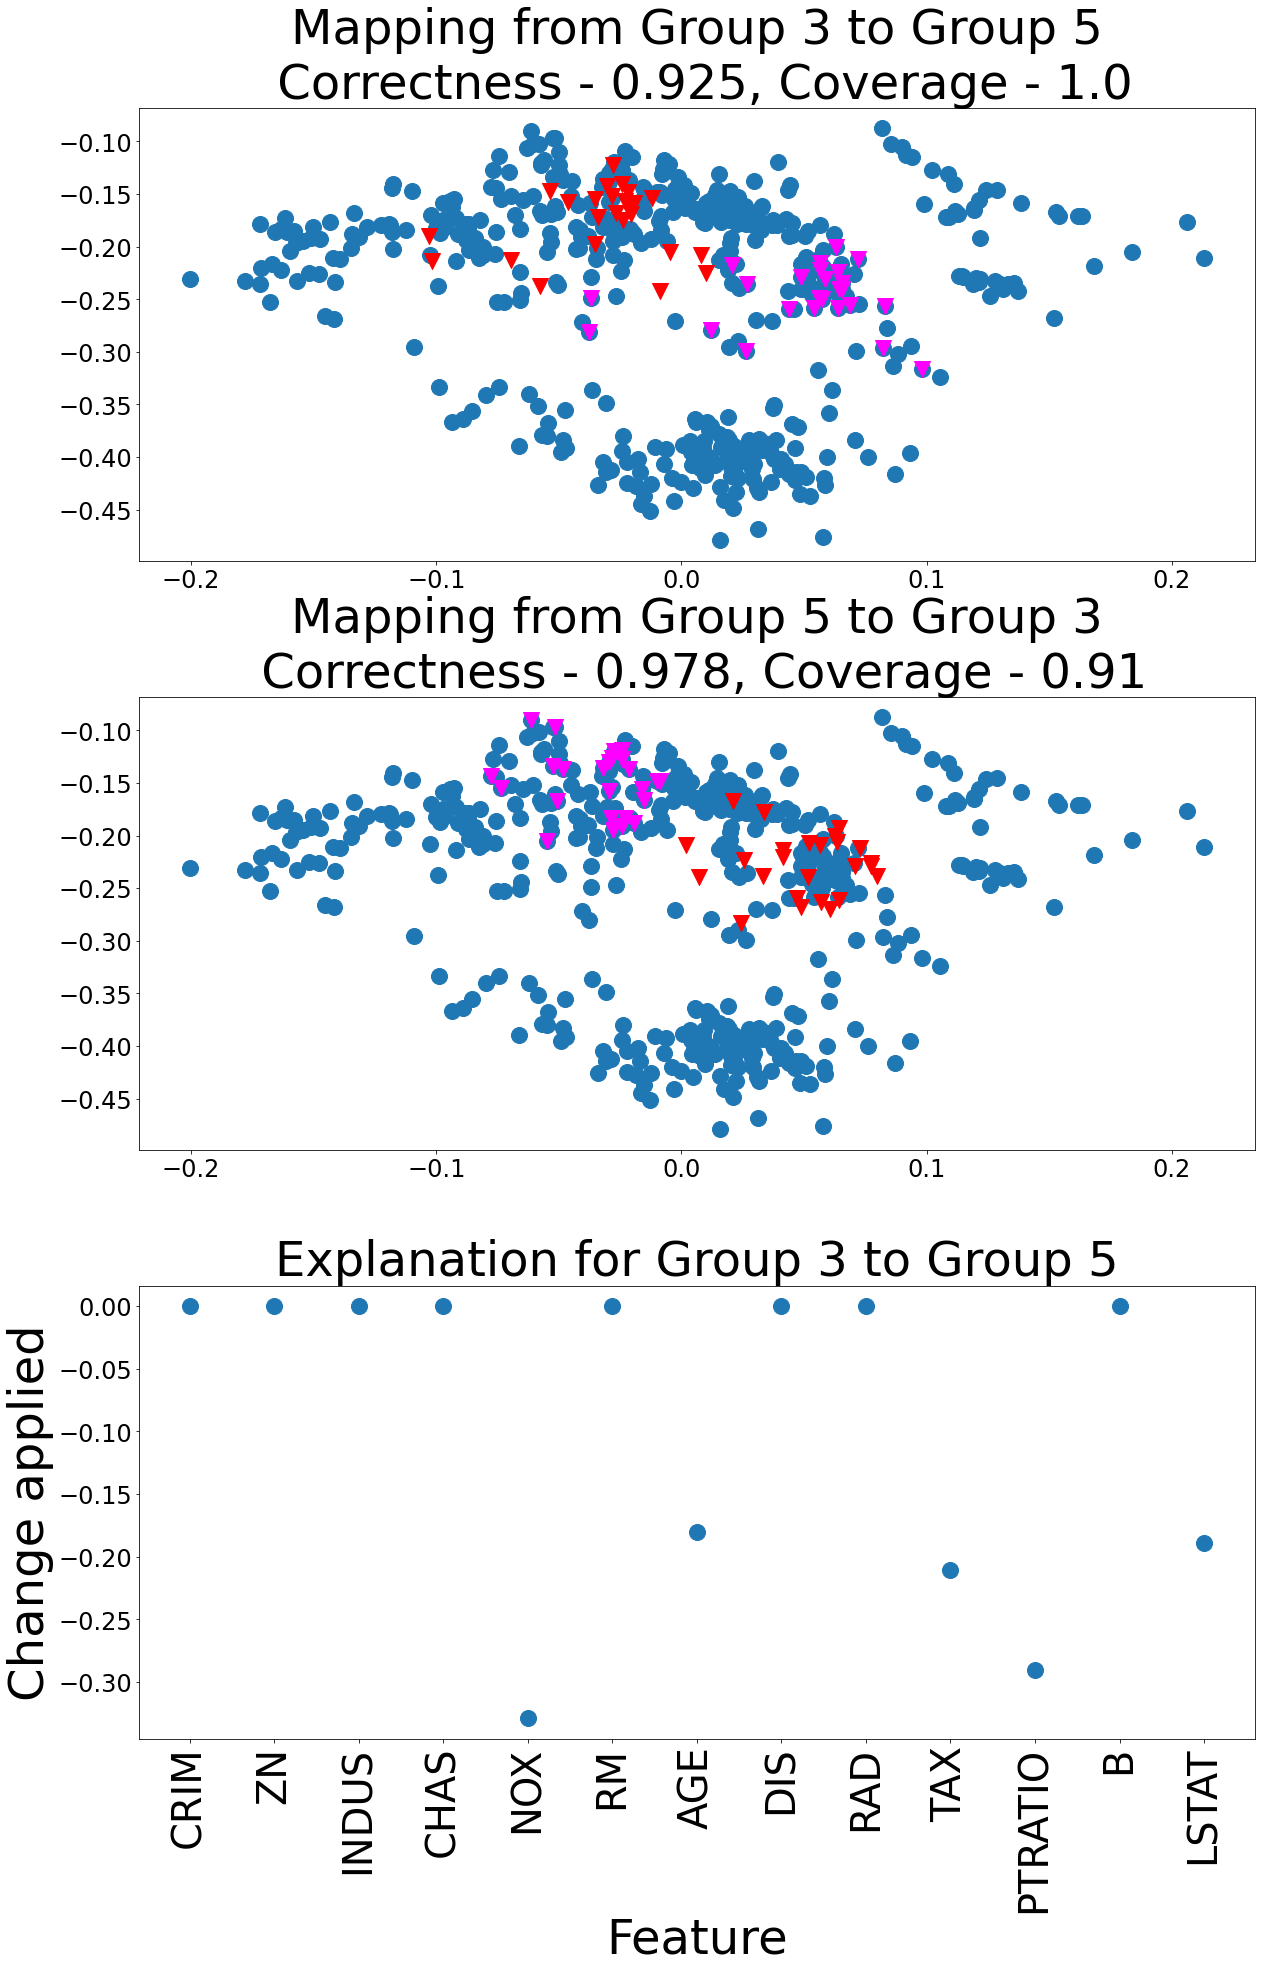

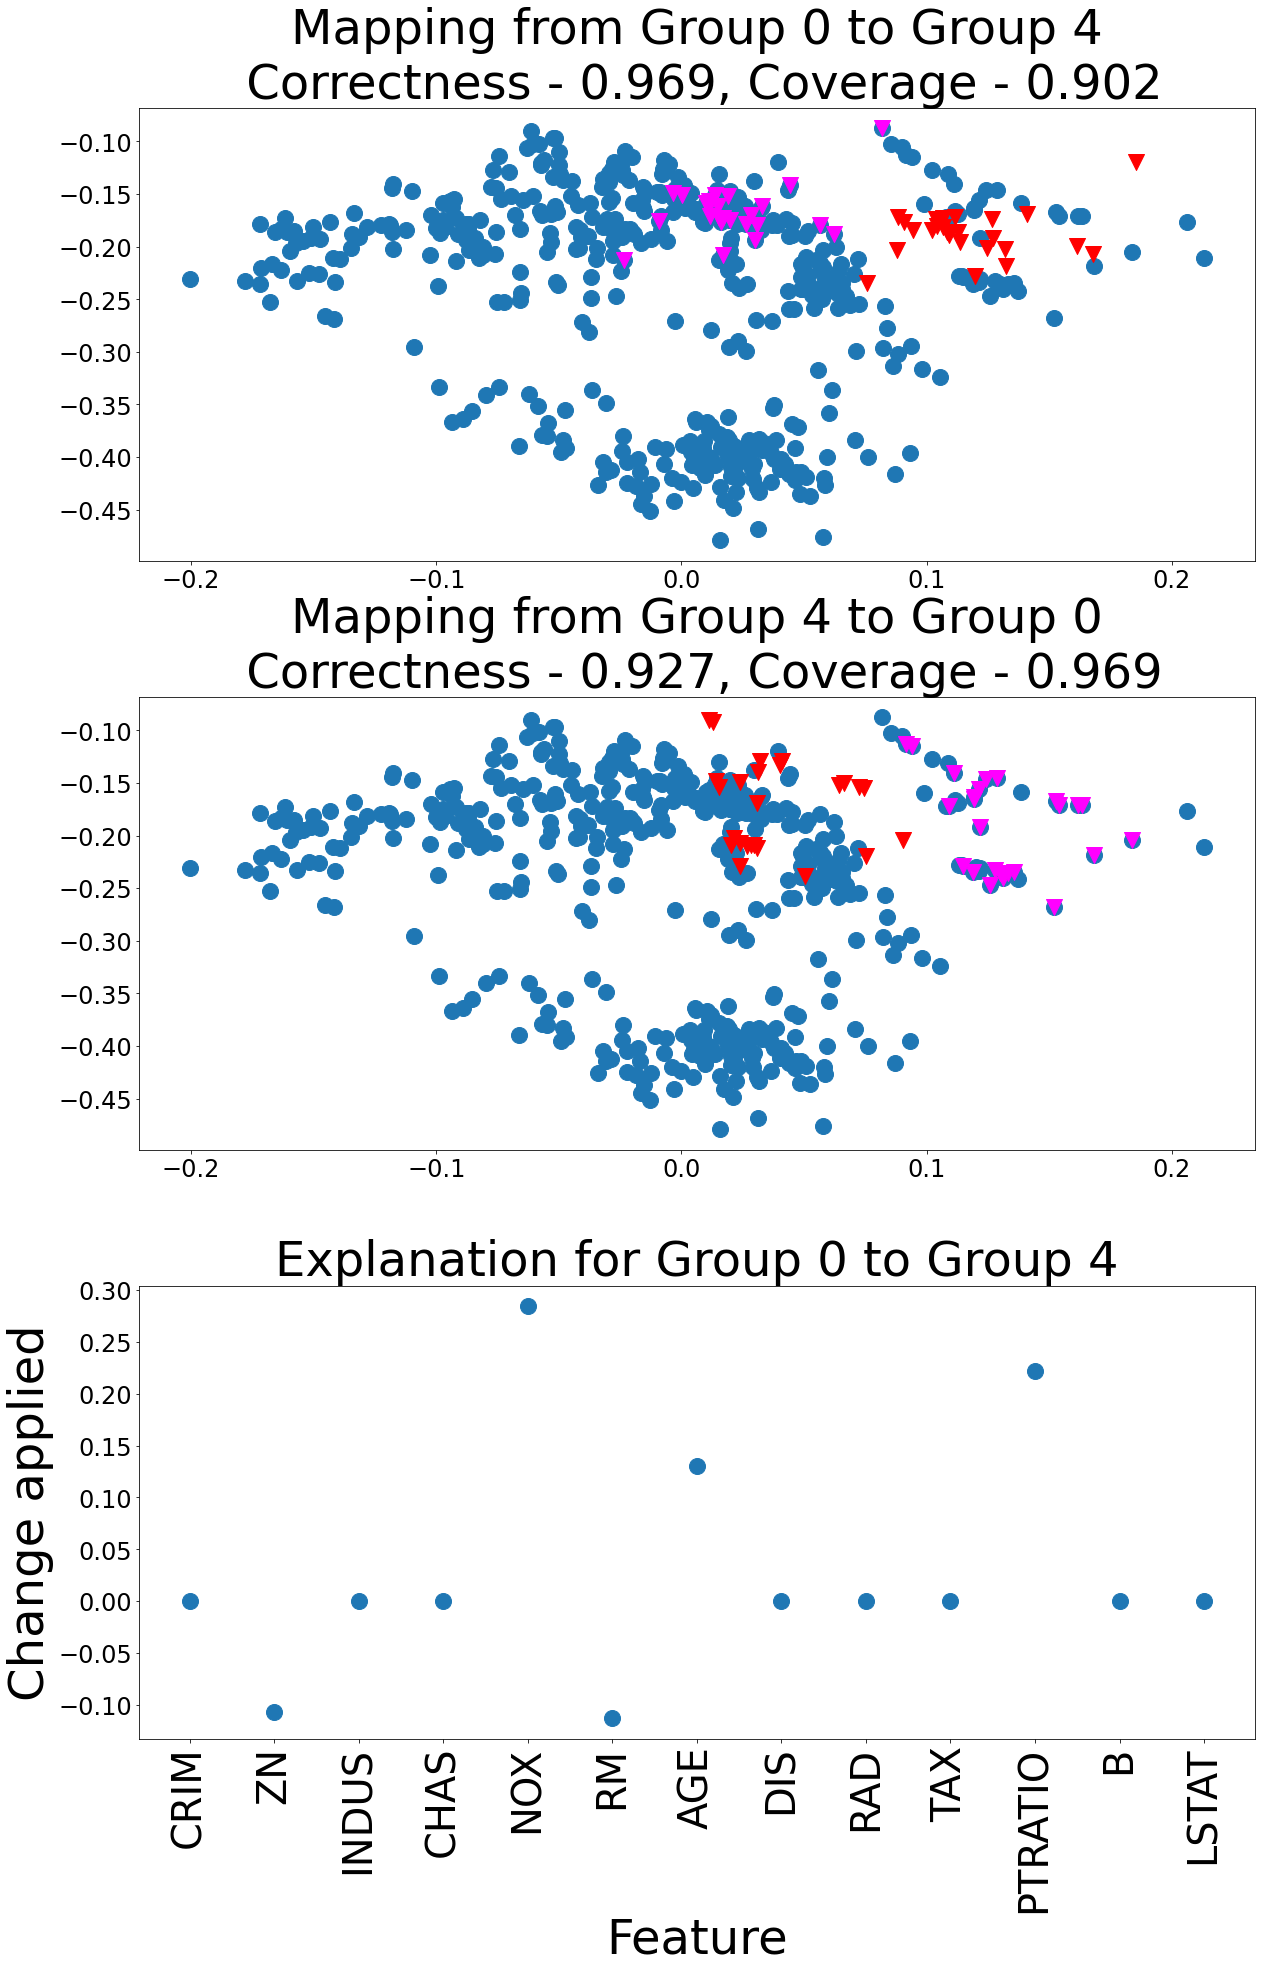

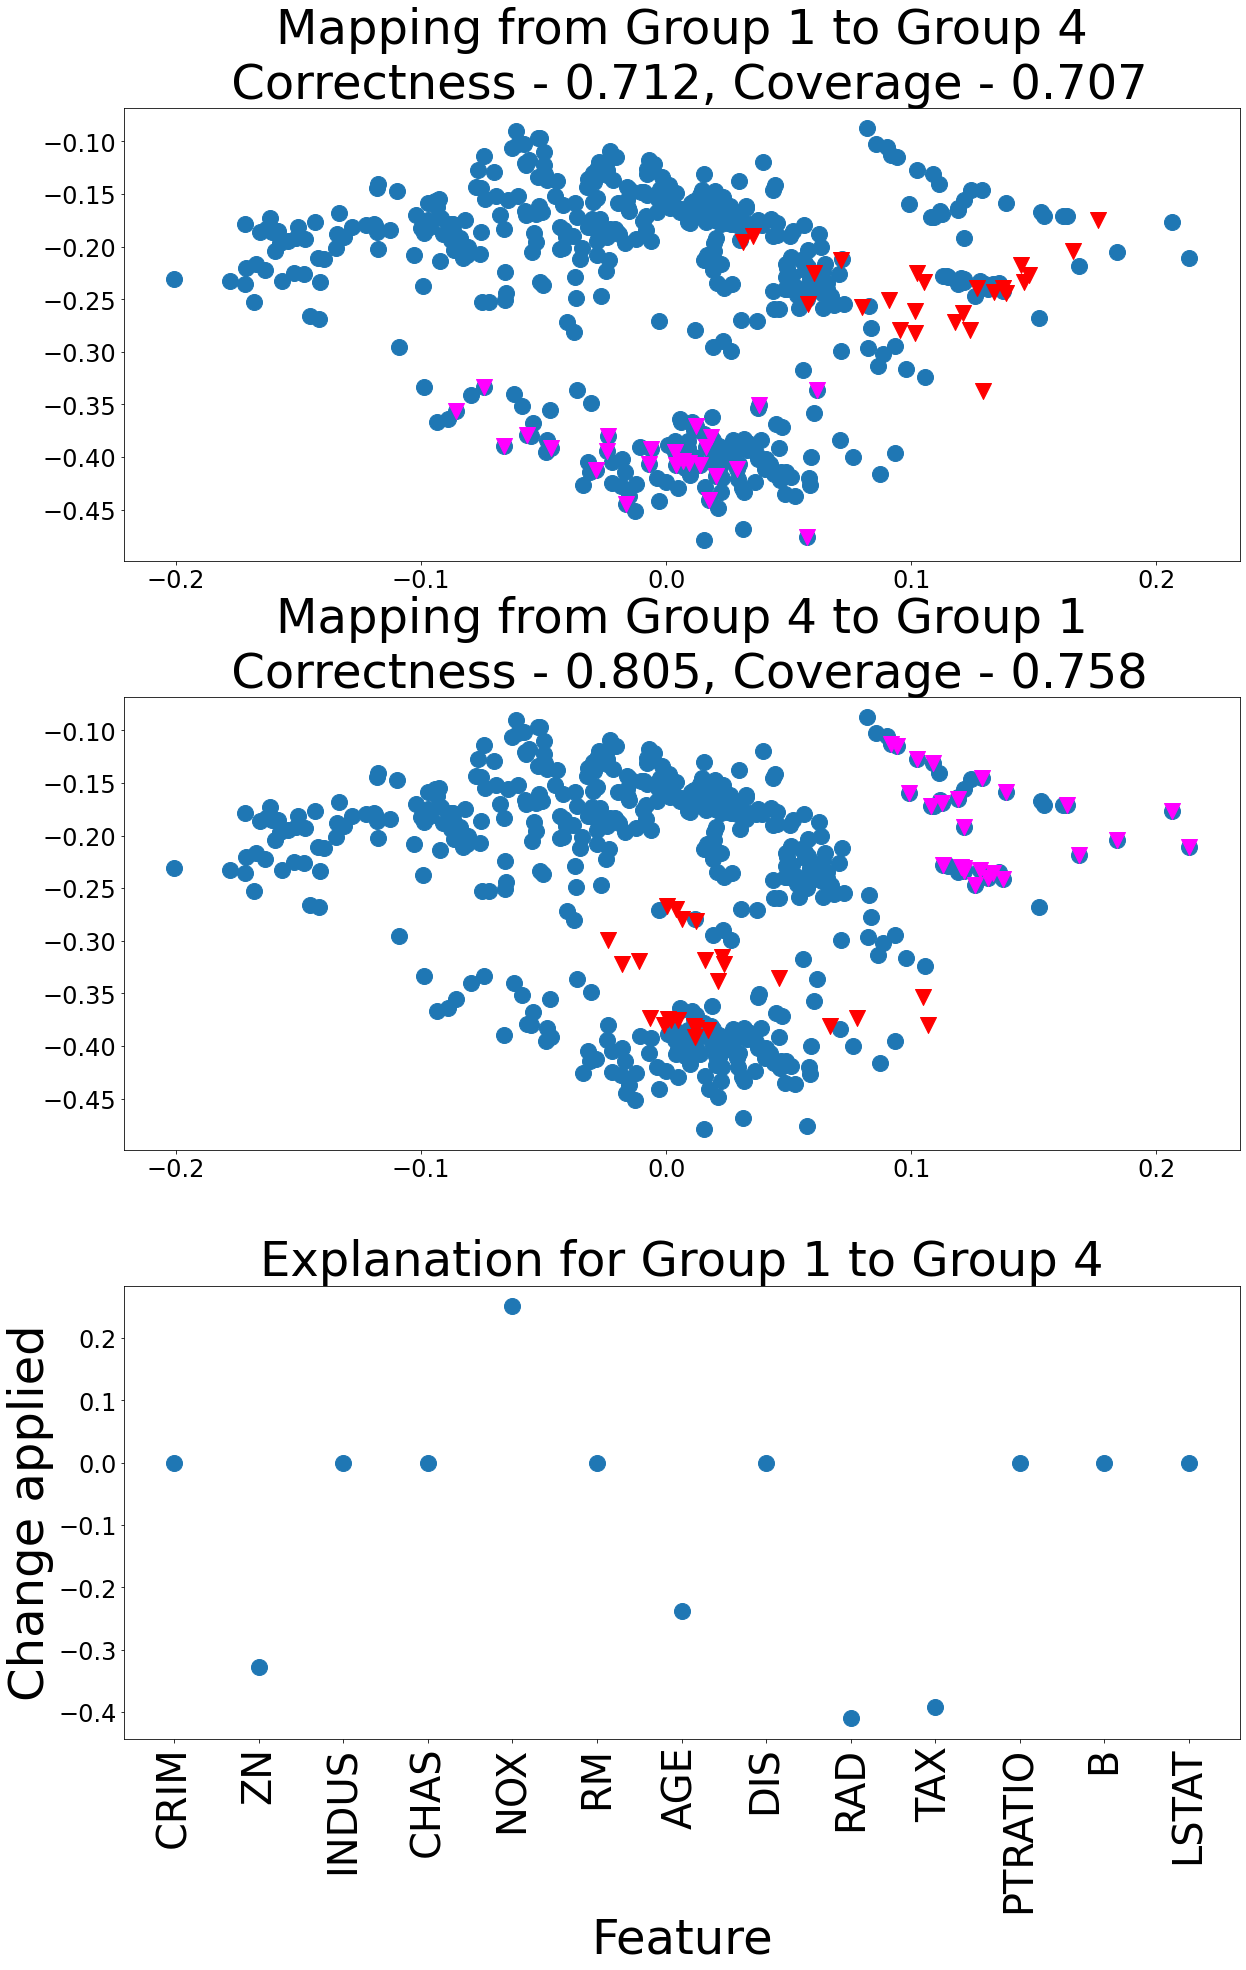

In [9]:
# Evaluate the explanations
from eldr.explain.explain_cs_copy import *
from eldr.plotter.myplot import *
k = 5
epsilon = 0.05
import torch
feature_names = ["CRIM", "ZN", "INDUS", "CHAS", "NOX", "RM", "AGE", "DIS", "RAD", "TAX", "PTRATIO", "B", "LSTAT"]

deltas_ = np.load("./deltas/deltas" + str(k) + ".npy")
np.set_printoptions(suppress=True)
print(deltas_)

Explainer = Explain(model, means, centers, dist='l1')

a, b = Explainer.metrics(torch.tensor(x), indices, torch.from_numpy(deltas_), epsilon, k = k)

plot_metrics(a, b, name = "housing-metrics.png")

plot_explanation(model, x, data_rep, indices, deltas_, a, b, 0, 2, k = k, num_points = 25, name = "housing-0to2.png", feature_names = feature_names)

plot_explanation(model, x, data_rep, indices, deltas_, a, b, 3, 5, k = k,  num_points = 25, name = "housing-3to5.png", feature_names = feature_names)

plot_explanation(model, x, data_rep, indices, deltas_, a, b, 0, 4, k = k,  num_points = 25, name = "housing-0to4.png", feature_names = feature_names)
plot_explanation(model, x, data_rep, indices, deltas_, a, b, 1, 4, k = k,  num_points = 25, name = "housing-1to4.png", feature_names = feature_names)

In [10]:
out = np.loadtxt("out.csv", delimiter = ",")
    
print(out)

[[ 1.          0.63325187  0.64148012  0.5348858   0.53648294]
 [ 3.          0.85918544  0.87363138  0.75659454  0.77882183]
 [ 5.          0.96097526  0.96186756  0.88246169  0.9007376 ]
 [ 7.          0.98233197  0.98021819  0.96656433  0.97966476]
 [ 9.          0.98150661  0.97913633  0.97919944  0.98764578]
 [11.          0.99030961  0.98631701  0.98177942  0.99011862]
 [13.          0.98714865  0.98353629  0.98318323  0.9905395 ]]


In [11]:
# Evaluate the stability of TGT as it finds sparser explanations
# Warning:  check the order of the elements of K to ensure the correct comparison is being made
from eldr.misc import *
K = out[:,0].astype(int).tolist()
S = np.zeros((len(K) - 1, 2))

for c in range(len(K) - 1):
    k_more = K[c]
    k_less = K[c + 1]
    
    d_more = np.load("./deltas/deltas" + str(k_more) + ".npy")
    d_less = np.load("./deltas/deltas" + str(k_less) + ".npy")

    res = np.ones((num_clusters, num_clusters))
    for i in range(num_clusters):
        for j in range(num_clusters):
            if i != j:
                e_more = load(d_more, k_more, i, j)
                e_less = load(d_less, k_less, i, j)
                res[i, j] = Explainer.similarity(e_more.numpy(), e_less.numpy())
        
    S[c, 0] = k_more
    S[c, 1] = np.mean(res)

In [ ]:
# Plot the comparison of TGT to DBM based on our metrics at varying degrees of sparsity

import matplotlib
matplotlib.rc("xtick", labelsize = 16)
matplotlib.rc("ytick", labelsize = 16)
matplotlib.rc("axes", titlesize = 24)
matplotlib.rc("axes", labelsize = 24)
#matplotlib.rc("lines", markersize = 16)

plt.plot(out[:, 0], out[:, 1], c = "C0", label = "Correctness - TGT")
plt.plot(out[:, 0], out[:, 3], ls = "--", c= "C0", label = "Correctness - DBM")
plt.plot(out[:, 0], out[:, 2], c = "orange", label = "Coverage - TGT")
plt.plot(out[:, 0], out[:, 4], ls = "--", color = "orange", label = "Coverage - DBM")
plt.plot(S[:, 0], S[:, 1], color = "C2", label = "Similarity - TGT")
plt.plot(S[:, 0], np.ones((len(K) - 1)), ls = "--", color = "C2", label = "Similarity - DBM")

#plt.ylabel("Metric")
plt.xlabel("Number of Features Used")
plt.xticks(np.arange(1, 15, step=2))
plt.title("UCI Boston Housing")

#plt.legend()

plt.savefig("housing-tradeoff.png", bbox_inches='tight')
plt.show()
plt.close()